<a href="https://colab.research.google.com/github/andrew-veriga/sunpower/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Получение данных из excel

In [99]:
import pandas as pd
import tensorflow as tf
import numpy as np
# df = pd.read_csv("https://github.com/andrew-veriga/sunpower/raw/master/SES_1_Cherny_Yar_-_gotovo.csv", parse_dates=["Дата"], index_col="Дата")
df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_1_Cherny_Yar_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
df.head()


,№ п/п,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Общая облачность,"Текущая погода, сообщаемая с метеорологической станции",Прошедшая погода между сроками наблюдения 1,Прошедшая погода между сроками наблюдения 2,"Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака","Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm",Высота основания самых низких облаков (м),"Высококучевые, высокослоистые и слоисто-дождевые облака","Перистые, перисто-кучевые и перисто-слоистые облака",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,,,,,,,,,,
2019-04-25 01:00:00.000,1,01:00:00,0.000000,9.1,766.4,766.9,68.0,247.5,2,Облаков нет.,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2019-04-25 04:00:00.000,2,04:00:00,0.147833,7.6,766.1,766.6,73.0,202.5,1,20–30%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Облаков нет.,"2500 или более, или облаков нет.","Высококучевых, высокослоистых или слоисто-дожд...",Перистые когтевидные или нитевидные или первые...,10.0
2019-04-25 06:59:59.995,3,07:00:00,5.024833,6.5,766.2,766.7,82.0,270.0,1,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.","Высококучевые просвечивающие, полосами, либо о...","Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-25 09:59:59.995,4,10:00:00,11.363389,18.8,766.7,767.2,34.0,90.0,1,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.",Высококучевые башенкообразные или хлопьевидные.,"Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-25 12:59:59.995,5,13:00:00,10.962667,23.0,766.3,766.9,22.0,90.0,2,20–30%.,,NaN,NaN,"Кучевые плоские или кучевые разорванные, или т...","10% или менее, но не 0",1000-1500,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0


доступные колонки

In [100]:
df.columns

Index(['№ п/п', 'Время', 'Мощность, МВт',
       'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
       'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
       'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
       'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
       'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
       'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
       'Общая облачность',
       'Текущая погода, сообщаемая с метеорологической станции ',
       'Прошедшая погода между сроками наблюдения 1',
       'Прошедшая погода между сроками наблюдения 2',
       'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые обла

Создание набора данных из числовых колонок

In [101]:
series = df[
            [
            'Время',
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            # 'Общая облачность',
            # 'Текущая погода, сообщаемая с метеорологической станции ',
            # 'Прошедшая погода между сроками наблюдения 1',
            # 'Прошедшая погода между сроками наблюдения 2',
            # 'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака',
            # 'Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm',
            # 'Высота основания самых низких облаков (м)',
            # 'Высококучевые, высокослоистые и слоисто-дождевые облака',
            # 'Перистые, перисто-кучевые и перисто-слоистые облака',
            'Горизонтальная дальность видимости (км)'
             ]].fillna(0)#.asfreq(None)
            
            
series.head()

,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,
2019-04-25 01:00:00.000,01:00:00,0.000000,9.1,766.4,766.9,68.0,247.5,2,10.0
2019-04-25 04:00:00.000,04:00:00,0.147833,7.6,766.1,766.6,73.0,202.5,1,10.0
2019-04-25 06:59:59.995,07:00:00,5.024833,6.5,766.2,766.7,82.0,270.0,1,10.0
2019-04-25 09:59:59.995,10:00:00,11.363389,18.8,766.7,767.2,34.0,90.0,1,10.0
2019-04-25 12:59:59.995,13:00:00,10.962667,23.0,766.3,766.9,22.0,90.0,2,10.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc893192f28>,
      dtype=object)

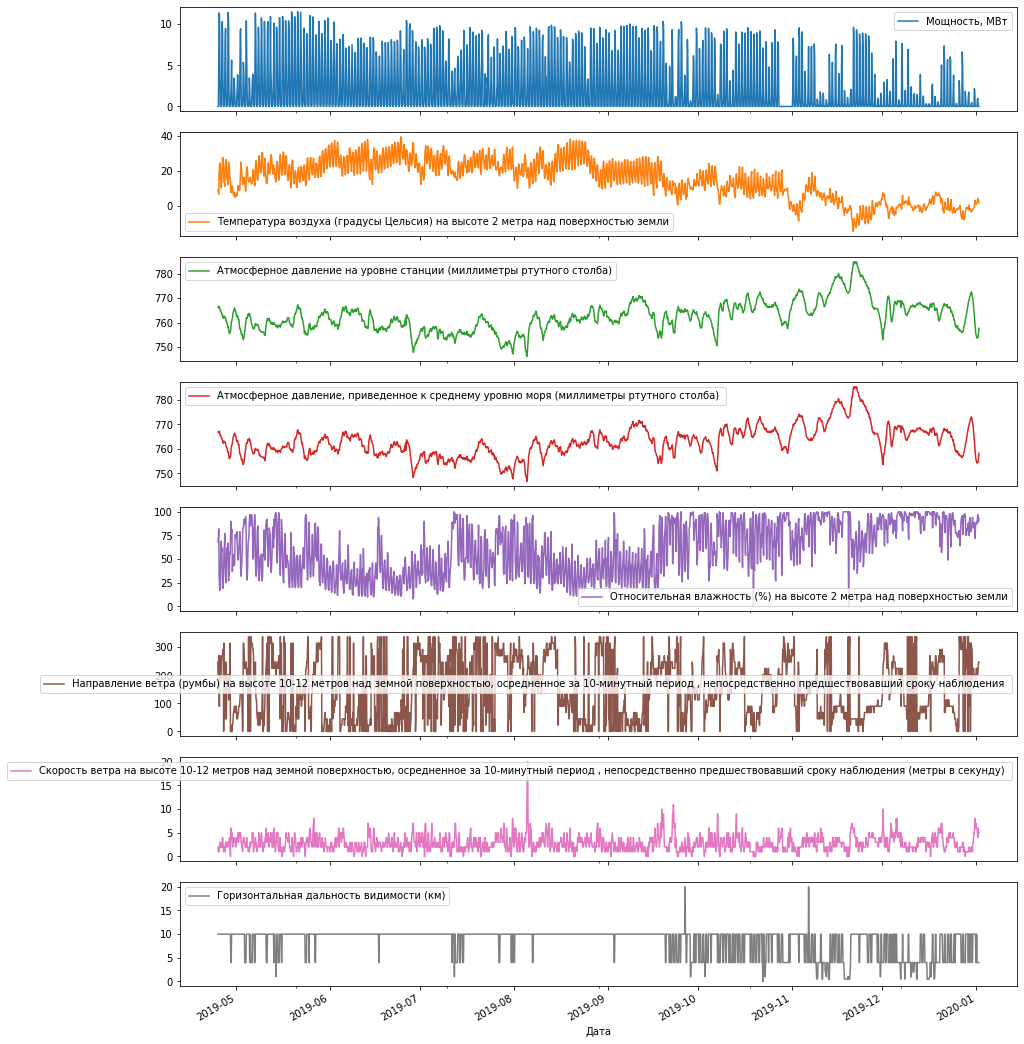

In [102]:
series.plot(subplots=True,figsize=(15,20))

###Создание датасета

In [0]:
split_datetime = 1500
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# data_mean = series[:split_datetime].mean(axis=0)
# data_std = series[:split_datetime].std(axis=0)

# series = (series-data_mean)/data_std

проба из https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
######################################
# past_history = window_size
# future_target = 1
# STEP = 1
# ds= series.values
# target = series['Мощность, МВт'].values
# x_train_single, y_train_single = multivariate_data(ds, target, 0,
#                                                    split_datetime, past_history,
#                                                    future_target, STEP,
#                                                    single_step=True)

In [0]:
series['Время']=series['Время'].map(lambda x: np.int(x.strftime('%H')))#.astype(np.string_)#.map(lambda x: x.strftime('%H'))
# series['Время'].astype(np.float32)

In [157]:
series['Время'] #= pd.to_numeric(series['Время'],errors='ignore')

Дата
2019-04-26 01:00:00.000     1
2019-04-26 04:00:00.000     4
2019-04-26 06:59:59.995     7
2019-04-26 09:59:59.995    10
2019-04-26 12:59:59.995    13
                           ..
2020-02-17 12:59:59.995    13
2020-02-17 15:59:59.995    16
2020-02-17 18:59:59.995    19
2020-02-17 21:59:59.995    22
2020-02-18 00:59:59.995     1
Name: Время, Length: 2385, dtype: int64

In [0]:

# target = series.pop('Мощность, МВт')

###Оформление оконного датасета

In [0]:

x_train = series[:split_datetime]
# y_train = target[:split_datetime]
x_valid = series[split_datetime:]
# y_valid = target[split_datetime:]

window_size = int(24/4*30)
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
  target_colnum=series.columns.get_loc(target)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1,target_colnum]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()

ds_train = windowed_dataset(x_train, 'Мощность, МВт', window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
ds_val_x = windowed_dataset(x_valid, 'Мощность, МВт', window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)


In [0]:
# target='Мощность, МВт'
# target_colnum=series.columns.get_loc(target)
# dataset = tf.data.Dataset.from_tensor_slices(series)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
# dataset = dataset.map(lambda window: (window[:-1], window[-1,target_colnum]))
# iterator = dataset.as_numpy_iterator()# tf.compat.v1.data.Iterator.from_structure(ds_train.output_types,ds_train.output_shapes)
# X, y = iterator.next()
# print(y)
# print(series[target][:window_size+1])

###Сборка и тренировка модели

In [145]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72, input_shape=(None, x_train.shape[1]), return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(72)),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
epoch_num=100
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(ds_train, validation_data=(ds_val_x), epochs=epoch_num)#,callbacks=[lr_schedule])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 12s 1s/step - loss: 12.1782 - mae: 2.8741 - val_loss: 4.5425 - val_mae: 1.7909
Epoch 2/100
11/11 [==============================] - 11s 1s/step - loss: 11.2285 - mae: 2.8583 - val_loss: 4.6936 - val_mae: 1.8577
Epoch 3/100
11/11 [==============================] - 11s 997ms/step - loss: 11.1494 - mae: 2.8528 - val_loss: 4.8413 - val_mae: 1.9225
Epoch 4/100
11/11 [==============================] - 11s 991ms/step - loss: 11.0416 - mae: 2.8388 - val_loss:

In [0]:
# import matplotlib.pyplot as plt
 
# lrs = 1e-8 * (10 ** (np.arange(200) / 20))
# plt.semilogx(lrs, history.history["val_loss"][:])
# plt.axis([1e-8, 200, 0, 20])

###Анализ функции потерь

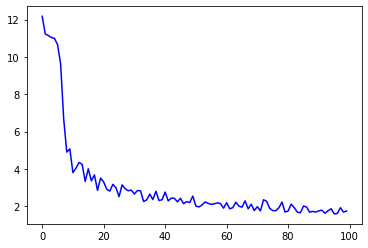

In [147]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[2.017301082611084, 1.9687275886535645, 2.0764389038085938, 2.236757516860962, 2.1586620807647705, 2.105973958969116, 2.137866735458374, 2.189730405807495, 2.1500868797302246, 1.9034972190856934, 2.194326400756836, 1.8710707426071167, 1.9286211729049683, 2.2208032608032227, 2.0117862224578857, 1.9573695659637451, 2.2961068153381348, 1.8713126182556152, 2.1168086528778076, 1.776727557182312, 1.984880805015564, 1.7579154968261719, 2.354449510574341, 2.2730798721313477, 1.8980625867843628, 1.7730298042297363, 1.7678993940353394, 1.9274293184280396, 2.2291018962860107, 1.697854995727539, 1.7495334148406982, 2.1219959259033203, 1.9282091856002808, 1.6914896965026855, 1.6579563617706299, 2.019059181213379, 1.9642924070358276, 1.6921299695968628, 1.7298659086227417, 1.697618007659912, 1.7595218420028687, 1.7973408699035645, 1.628794550895691, 1.771091103553772, 1.8713082075119019, 1.5960549116134644, 1.6167887449264526, 1.9301120042800903, 1.6943491697311401, 1.7483652830123901]


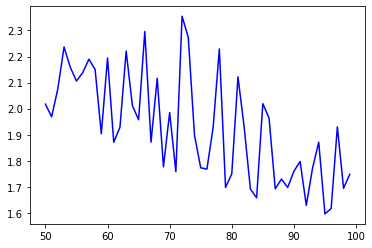

In [148]:
# Plot all but the first 10
loss = history.history['loss']
startpos= 50
epochs = range(50, len(loss))
plot_loss = loss[50:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

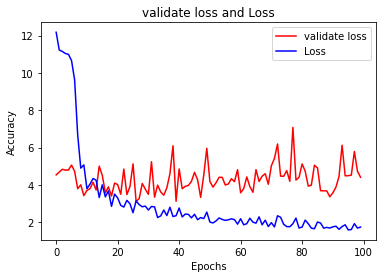

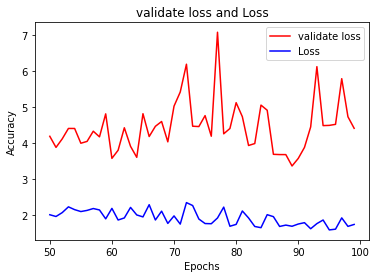

<Figure size 432x288 with 0 Axes>

In [150]:
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validate loss and Loss
#------------------------------------------------
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = val_loss[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed validate loss and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

### График сравнения предсказанной мощности с реальной, взятой из таблице

In [0]:
forecast=[]
for t in range(len(series) - window_size):
  pred=np.expand_dims(series[t:t+window_size],0)
  forecast.append(model.predict(pred).flatten())

results = forecast[split_datetime-window_size:]
results = np.array(results)#[:, 0, 0]




In [0]:
def plot_series(time, series, format="-", start=0, end=None, legend=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(legend)
    plt.grid(True)

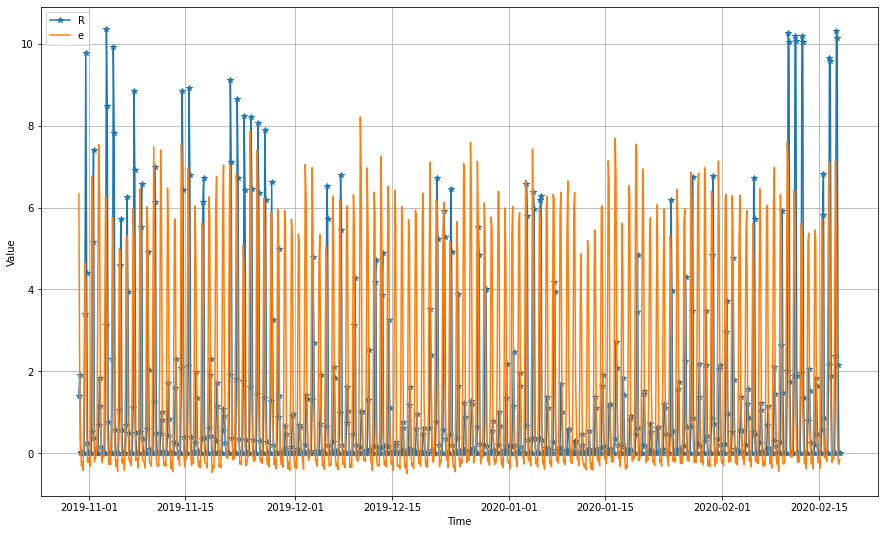

In [161]:
#import matplotlib.pyplot as plt

time_train = x_valid.index.to_numpy(dtype=np.datetime64)
plt.figure(figsize=(15, 9))
# plt.legend(['res', 'power'])
plot_series(time_train, x_valid['Мощность, МВт'], format='-*', legend='Power')
plot_series(time_train, results,  legend='Result')

In [154]:
Dosang = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_5_Dosang_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
Dosang.head()

,№ п/п,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Общая облачность,"Текущая погода, сообщаемая с метеорологической станции",Прошедшая погода между сроками наблюдения 1,Прошедшая погода между сроками наблюдения 2,"Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака","Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm",Высота основания самых низких облаков (м),"Высококучевые, высокослоистые и слоисто-дождевые облака","Перистые, перисто-кучевые и перисто-слоистые облака",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,,,,,,,,,,
2019-04-26 01:00:00.000,1,01:00:00,0.000000,10.0,764.4,764.9,69.0,225.0,2,20–30%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Облаков нет.,"2500 или более, или облаков нет.","Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0
2019-04-26 04:00:00.000,2,04:00:00,0.000000,13.6,764.1,764.5,57.0,247.5,3,70 – 80%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",70 – 80%.,"2500 или более, или облаков нет.",Высококучевые башенкообразные или хлопьевидные.,"Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-26 06:59:59.995,3,07:00:00,0.166333,13.3,763.6,764.2,62.0,270.0,2,"90 или более, но не 100%",,NaN,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.","10% или менее, но не 0",1000-1500,"Высококучевые просвечивающие, расположенные на...","Перистые нитевидные, иногда когтевидные, не ра...",10.0
2019-04-26 09:59:59.995,4,10:00:00,5.604889,21.3,763.6,764.0,41.0,270.0,2,50%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",50%.,"2500 или более, или облаков нет.","Высококучевые просвечивающие, полосами, либо о...","Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-26 12:59:59.995,5,13:00:00,11.393389,26.9,762.7,763.3,20.0,270.0,4,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.","Высококучевые просвечивающие, полосами, либо о...","Перистых, перисто-кучевых или перисто-слоистых...",10.0


In [155]:
series = Dosang[
            [
            'Время',
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            # 'Общая облачность',
            # 'Текущая погода, сообщаемая с метеорологической станции ',
            # 'Прошедшая погода между сроками наблюдения 1',
            # 'Прошедшая погода между сроками наблюдения 2',
            # 'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака',
            # 'Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm',
            # 'Высота основания самых низких облаков (м)',
            # 'Высококучевые, высокослоистые и слоисто-дождевые облака',
            # 'Перистые, перисто-кучевые и перисто-слоистые облака',
            'Горизонтальная дальность видимости (км)'
             ]].fillna(0)#.asfreq(None)
            
            
series.head()

,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,
2019-04-26 01:00:00.000,01:00:00,0.000000,10.0,764.4,764.9,69.0,225.0,2,10.0
2019-04-26 04:00:00.000,04:00:00,0.000000,13.6,764.1,764.5,57.0,247.5,3,10.0
2019-04-26 06:59:59.995,07:00:00,0.166333,13.3,763.6,764.2,62.0,270.0,2,10.0
2019-04-26 09:59:59.995,10:00:00,5.604889,21.3,763.6,764.0,41.0,270.0,2,10.0
2019-04-26 12:59:59.995,13:00:00,11.393389,26.9,762.7,763.3,20.0,270.0,4,10.0
